In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments, pipeline
from peft import PeftModel, PeftConfig, LoraConfig, TaskType, get_peft_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os

In [2]:
model_name = "allegro/herbert-base-cased"
device = "mps"

In [3]:
data_path = "augmented_texts_bert.csv"
df = pd.read_csv(data_path)

print("First few entries:")
df.head()

First few entries:


,text,label
0,"Lakier roweru bardzo kiepskiej jakości , robią...",Negative
1,Nie jestem zadowolony z zakupu . Przede wszyst...,Negative
2,Szukając klucze tej wielkości brał em dwa pod ...,Neutral
3,Długo szukała m odpowiedniego fotelika dla bar...,Neutral
4,Kupił em pociąg ( w zestawie kilka torów prost...,Negative


In [4]:
class_counts = df['label'].value_counts()
print("\nClass Counts:")
print(class_counts)

min_count = class_counts.min()
print(f"\nMinimum class count: {min_count}")


Class Counts:
label
Neutral     750
Positive    415
Negative    335
Name: count, dtype: int64

Minimum class count: 335


In [5]:
random_seed = 42

df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=random_seed)).reset_index(drop=True)

print("\nBalanced Label Distribution:")
print(df_balanced['label'].value_counts(normalize=True) * 100)


Balanced Label Distribution:
label
Negative    33.333333
Neutral     33.333333
Positive    33.333333
Name: proportion, dtype: float64


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_13457/1788761823.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=random_seed)).reset_index(drop=True)


In [6]:
train_df, test_df = train_test_split(
    df_balanced, 
    test_size=0.2, 
    random_state=42, 
    # stratify=df['label']
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 804
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 201
    })
})

In [7]:
print("Unique Labels:", sorted(df['label'].unique()))
print("Number of Labels:", len(sorted(df['label'].unique())))

print("Training Set Label Distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\nTest Set Label Distribution:")
print(test_df['label'].value_counts(normalize=True) * 100)      # 41.46341463414634

Unique Labels: ['Negative', 'Neutral', 'Positive']
Number of Labels: 3
Training Set Label Distribution:
label
Positive    33.830846
Negative    33.084577
Neutral     33.084577
Name: proportion, dtype: float64

Test Set Label Distribution:
label
Neutral     34.328358
Negative    34.328358
Positive    31.343284
Name: proportion, dtype: float64


In [8]:
for entry in dataset['train'].select(range(3)):
    print('INPUT: {} \nOUTPUT: {}\n'.format(entry['text'], entry['label']))

INPUT: Mylący tytuł który sugeruje że mamy opisy czynienia z dziełem Smitha , w Autor w książce zawarte są tylko zamyka Bogactwa Narodów oraz Teorii Uczuć Moralnych , i że są niestety bardzo kiepskim komentarzem jak się cyta AUTORA KSIĄŻKI na NIE JEST ADAM SMITH ! TO sprawia wrażenie jakby ktoś kazał mu napisać tą do , momentami odczuwa się wręcz jego , do Smitha niechęć dezaprobatę względem jego dzieła . Ogólnie to streszczenie książkę recenzję - ry nazwanie tego książką było by sporą przesadą samo ciężko się czyta . Jedyne co sprawia rzeczywistości ocena wynosi ponad 1 to że pojawiają się dokładne cytaty . 
OUTPUT: Negative

INPUT: Niestety w ać testach wypadł strasznie marnie . Prędkość zapisu dużego pojedynczego pliku ane USB 2 . 0 to 5MB / s i nie chce , szybciej . Obojętne czy że czy na . Kupił em 2 a nie na każdym taka żenada . Wstyd n Patriota . z i przez producenta są wyssane z palca ( rozumiem być to dane Zale USB 3 . 0 , ale na USB 2 . 0 powinno być duuuużo lepiej ) . Plus t

In [9]:
train_counts = pd.DataFrame({'Diagnosis': train_df['label']})
train_counts = train_counts.groupby('Diagnosis').size().reset_index(name='train_set')

test_counts = pd.DataFrame({'Diagnosis': test_df['label']})
test_counts = test_counts.groupby('Diagnosis').size().reset_index(name='test_set')

display(train_counts.merge(test_counts, on='Diagnosis'))

,Diagnosis,train_set,test_set
0,Negative,266,69
1,Neutral,266,69
2,Positive,272,63


In [10]:
sorted_labels = sorted(set(df['label']))
label2id = {label: idx for idx, label in enumerate(sorted_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Label to ID mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
ID to Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [11]:

tokenizer = AutoTokenizer.from_pretrained(model_name)

foundation_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

classifier = pipeline("text-classification", model=foundation_model, tokenizer=tokenizer, device=device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
print("Evaluating foundation model before fine-tuning...")

test_encodings = tokenizer(test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

foundation_model.to(device)
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

with torch.no_grad():
    outputs = foundation_model(**test_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# Calculate accuracy
test_labels = test_df['label'].map(label2id).values
foundation_accuracy = round(np.mean(predictions == test_labels) * 100, 2)
print(f"Foundation Model Accuracy: {foundation_accuracy}%")

Evaluating foundation model before fine-tuning...
Foundation Model Accuracy: 34.33%


In [13]:
print("Number of Labels in Model:", foundation_model.config.num_labels)

Number of Labels in Model: 3


In [14]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=64, 
    lora_alpha=1, 
    lora_dropout=0.1
)

peft_model = get_peft_model(foundation_model, lora_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [15]:
peft_model.print_trainable_parameters()

trainable params: 2,361,603 || all params: 126,806,790 || trainable%: 1.8624


In [16]:
def preprocess_function(examples):
    """Preprocess the dataset by returning tokenized examples."""
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokens['labels'] = [label2id[l] for l in examples["label"]]
    return tokens

tokenized_ds = dataset.map(preprocess_function, batched=True, remove_columns=["label"])

print(tokenized_ds)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 804
    })
    test: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 201
    })
})


In [17]:
print("A tokenized training input example:")
# text
print(tokenized_ds["train"][0]["text"])
# tokens
print(tokenized_ds["train"][0]["input_ids"])
print("\n")
print("A tokenized training label example:")
print(tokenized_ds["train"][0]["labels"])

A tokenized training input example:
Mylący tytuł który sugeruje że mamy opisy czynienia z dziełem Smitha , w Autor w książce zawarte są tylko zamyka Bogactwa Narodów oraz Teorii Uczuć Moralnych , i że są niestety bardzo kiepskim komentarzem jak się cyta AUTORA KSIĄŻKI na NIE JEST ADAM SMITH ! TO sprawia wrażenie jakby ktoś kazał mu napisać tą do , momentami odczuwa się wręcz jego , do Smitha niechęć dezaprobatę względem jego dzieła . Ogólnie to streszczenie książkę recenzję - ry nazwanie tego książką było by sporą przesadą samo ciężko się czyta . Jedyne co sprawia rzeczywistości ocena wynosi ponad 1 to że pojawiają się dokładne cytaty .
[0, 3838, 80, 2469, 6484, 2377, 24704, 2040, 3552, 36433, 9778, 1046, 21610, 18717, 22498, 1947, 1019, 14970, 1019, 14169, 11750, 2264, 2308, 24500, 25729, 6953, 23733, 2248, 2516, 2034, 2526, 57, 15009, 2569, 13701, 1947, 1009, 2040, 2264, 6573, 2450, 17696, 2502, 12797, 5021, 2217, 2022, 2141, 2148, 13551, 11196, 29895, 190, 273, 5529, 1998, 5985, 478

In [18]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = (predictions == labels).mean() * 100
    return {"accuracy": accuracy}

trainer = Trainer(
    model=peft_model,
    args=TrainingArguments(
        output_dir="herbert-lora",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=15,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        logging_steps=10,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1515 [00:00<?, ?it/s]

{'loss': 1.1004, 'grad_norm': 7.498218536376953, 'learning_rate': 1.986798679867987e-05, 'epoch': 0.1}
{'loss': 1.1099, 'grad_norm': 4.744424819946289, 'learning_rate': 1.9735973597359735e-05, 'epoch': 0.2}
{'loss': 1.0862, 'grad_norm': 2.0803000926971436, 'learning_rate': 1.9603960396039604e-05, 'epoch': 0.3}
{'loss': 1.1109, 'grad_norm': 2.539564371109009, 'learning_rate': 1.9471947194719475e-05, 'epoch': 0.4}
{'loss': 1.1053, 'grad_norm': 7.016798496246338, 'learning_rate': 1.9339933993399344e-05, 'epoch': 0.5}
{'loss': 1.1265, 'grad_norm': 7.110602855682373, 'learning_rate': 1.920792079207921e-05, 'epoch': 0.59}
{'loss': 1.0998, 'grad_norm': 3.8362019062042236, 'learning_rate': 1.9075907590759077e-05, 'epoch': 0.69}
{'loss': 1.0826, 'grad_norm': 2.5029361248016357, 'learning_rate': 1.8943894389438946e-05, 'epoch': 0.79}
{'loss': 1.1388, 'grad_norm': 3.0307815074920654, 'learning_rate': 1.881188118811881e-05, 'epoch': 0.89}
{'loss': 1.0908, 'grad_norm': 3.979762554168701, 'learning_

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0941499471664429, 'eval_accuracy': 33.33333333333333, 'eval_runtime': 10.3621, 'eval_samples_per_second': 19.398, 'eval_steps_per_second': 2.509, 'epoch': 1.0}
{'loss': 1.1189, 'grad_norm': 2.8685848712921143, 'learning_rate': 1.8547854785478548e-05, 'epoch': 1.09}
{'loss': 1.0835, 'grad_norm': 4.66773796081543, 'learning_rate': 1.841584158415842e-05, 'epoch': 1.19}
{'loss': 1.1004, 'grad_norm': 4.6671142578125, 'learning_rate': 1.8283828382838285e-05, 'epoch': 1.29}
{'loss': 1.1022, 'grad_norm': 6.648125648498535, 'learning_rate': 1.8151815181518153e-05, 'epoch': 1.39}
{'loss': 1.0933, 'grad_norm': 4.380995273590088, 'learning_rate': 1.8019801980198022e-05, 'epoch': 1.49}
{'loss': 1.1027, 'grad_norm': 6.217434406280518, 'learning_rate': 1.788778877887789e-05, 'epoch': 1.58}
{'loss': 1.0867, 'grad_norm': 7.330850601196289, 'learning_rate': 1.7755775577557755e-05, 'epoch': 1.68}
{'loss': 1.109, 'grad_norm': 5.189874172210693, 'learning_rate': 1.7623762376237624e-05, 'epo

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0906410217285156, 'eval_accuracy': 34.32835820895522, 'eval_runtime': 10.067, 'eval_samples_per_second': 19.966, 'eval_steps_per_second': 2.583, 'epoch': 2.0}
{'loss': 1.0683, 'grad_norm': 2.923365831375122, 'learning_rate': 1.722772277227723e-05, 'epoch': 2.08}
{'loss': 1.0912, 'grad_norm': 3.989041566848755, 'learning_rate': 1.7095709570957098e-05, 'epoch': 2.18}
{'loss': 1.1001, 'grad_norm': 5.70626974105835, 'learning_rate': 1.6963696369636966e-05, 'epoch': 2.28}
{'loss': 1.0878, 'grad_norm': 2.5894131660461426, 'learning_rate': 1.683168316831683e-05, 'epoch': 2.38}
{'loss': 1.0708, 'grad_norm': 2.5993032455444336, 'learning_rate': 1.66996699669967e-05, 'epoch': 2.48}
{'loss': 1.0927, 'grad_norm': 9.186674118041992, 'learning_rate': 1.656765676567657e-05, 'epoch': 2.57}
{'loss': 1.0962, 'grad_norm': 2.285195827484131, 'learning_rate': 1.6435643564356436e-05, 'epoch': 2.67}
{'loss': 1.0984, 'grad_norm': 4.860506057739258, 'learning_rate': 1.6303630363036305e-05, 'epo

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0887565612792969, 'eval_accuracy': 36.81592039800995, 'eval_runtime': 10.1949, 'eval_samples_per_second': 19.716, 'eval_steps_per_second': 2.55, 'epoch': 3.0}
{'loss': 1.0796, 'grad_norm': 3.488325357437134, 'learning_rate': 1.5907590759075907e-05, 'epoch': 3.07}
{'loss': 1.0971, 'grad_norm': 4.165440082550049, 'learning_rate': 1.5775577557755775e-05, 'epoch': 3.17}
{'loss': 1.0897, 'grad_norm': 2.2079100608825684, 'learning_rate': 1.5643564356435644e-05, 'epoch': 3.27}
{'loss': 1.0989, 'grad_norm': 7.262924671173096, 'learning_rate': 1.5511551155115512e-05, 'epoch': 3.37}
{'loss': 1.0708, 'grad_norm': 5.127209663391113, 'learning_rate': 1.537953795379538e-05, 'epoch': 3.47}
{'loss': 1.0809, 'grad_norm': 8.65412712097168, 'learning_rate': 1.5247524752475249e-05, 'epoch': 3.56}
{'loss': 1.1022, 'grad_norm': 3.971869707107544, 'learning_rate': 1.5115511551155118e-05, 'epoch': 3.66}
{'loss': 1.0854, 'grad_norm': 3.712622880935669, 'learning_rate': 1.4983498349834984e-05, '

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0868178606033325, 'eval_accuracy': 36.81592039800995, 'eval_runtime': 9.6223, 'eval_samples_per_second': 20.889, 'eval_steps_per_second': 2.702, 'epoch': 4.0}
{'loss': 1.0976, 'grad_norm': 2.8748927116394043, 'learning_rate': 1.4587458745874588e-05, 'epoch': 4.06}
{'loss': 1.0903, 'grad_norm': 3.7005231380462646, 'learning_rate': 1.4455445544554456e-05, 'epoch': 4.16}
{'loss': 1.094, 'grad_norm': 2.7712621688842773, 'learning_rate': 1.4323432343234325e-05, 'epoch': 4.26}
{'loss': 1.084, 'grad_norm': 4.698450088500977, 'learning_rate': 1.4191419141914193e-05, 'epoch': 4.36}
{'loss': 1.1044, 'grad_norm': 3.0735666751861572, 'learning_rate': 1.405940594059406e-05, 'epoch': 4.46}
{'loss': 1.1149, 'grad_norm': 6.546907901763916, 'learning_rate': 1.3927392739273929e-05, 'epoch': 4.55}
{'loss': 1.0752, 'grad_norm': 2.46818208694458, 'learning_rate': 1.3795379537953797e-05, 'epoch': 4.65}
{'loss': 1.089, 'grad_norm': 4.649681091308594, 'learning_rate': 1.3663366336633666e-05, '

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0857892036437988, 'eval_accuracy': 37.81094527363184, 'eval_runtime': 9.9079, 'eval_samples_per_second': 20.287, 'eval_steps_per_second': 2.624, 'epoch': 5.0}
{'loss': 1.0992, 'grad_norm': 2.559757709503174, 'learning_rate': 1.326732673267327e-05, 'epoch': 5.05}
{'loss': 1.1004, 'grad_norm': 8.51381778717041, 'learning_rate': 1.3135313531353136e-05, 'epoch': 5.15}
{'loss': 1.1003, 'grad_norm': 4.6381306648254395, 'learning_rate': 1.3003300330033004e-05, 'epoch': 5.25}
{'loss': 1.0886, 'grad_norm': 5.615410327911377, 'learning_rate': 1.2871287128712873e-05, 'epoch': 5.35}
{'loss': 1.0585, 'grad_norm': 3.6866633892059326, 'learning_rate': 1.2739273927392741e-05, 'epoch': 5.45}
{'loss': 1.1062, 'grad_norm': 5.724693298339844, 'learning_rate': 1.2607260726072608e-05, 'epoch': 5.54}
{'loss': 1.0512, 'grad_norm': 4.854454040527344, 'learning_rate': 1.2475247524752477e-05, 'epoch': 5.64}
{'loss': 1.1084, 'grad_norm': 8.668760299682617, 'learning_rate': 1.2343234323432345e-05, 

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.083838939666748, 'eval_accuracy': 46.766169154228855, 'eval_runtime': 10.0835, 'eval_samples_per_second': 19.934, 'eval_steps_per_second': 2.578, 'epoch': 6.0}
{'loss': 1.0973, 'grad_norm': 3.8512303829193115, 'learning_rate': 1.1947194719471949e-05, 'epoch': 6.04}
{'loss': 1.0888, 'grad_norm': 6.3290863037109375, 'learning_rate': 1.1815181518151817e-05, 'epoch': 6.14}
{'loss': 1.0891, 'grad_norm': 2.7163729667663574, 'learning_rate': 1.1683168316831684e-05, 'epoch': 6.24}
{'loss': 1.0544, 'grad_norm': 6.199639320373535, 'learning_rate': 1.1551155115511552e-05, 'epoch': 6.34}
{'loss': 1.0869, 'grad_norm': 3.371776819229126, 'learning_rate': 1.141914191419142e-05, 'epoch': 6.44}
{'loss': 1.0797, 'grad_norm': 6.431469440460205, 'learning_rate': 1.1287128712871288e-05, 'epoch': 6.53}
{'loss': 1.0929, 'grad_norm': 4.022508144378662, 'learning_rate': 1.1155115511551156e-05, 'epoch': 6.63}
{'loss': 1.0978, 'grad_norm': 3.90221905708313, 'learning_rate': 1.1023102310231025e-05

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0826672315597534, 'eval_accuracy': 45.27363184079602, 'eval_runtime': 9.8856, 'eval_samples_per_second': 20.333, 'eval_steps_per_second': 2.63, 'epoch': 7.0}
{'loss': 1.0946, 'grad_norm': 3.0416975021362305, 'learning_rate': 1.0627062706270628e-05, 'epoch': 7.03}
{'loss': 1.0857, 'grad_norm': 3.795430898666382, 'learning_rate': 1.0495049504950497e-05, 'epoch': 7.13}
{'loss': 1.0818, 'grad_norm': 3.6003940105438232, 'learning_rate': 1.0363036303630365e-05, 'epoch': 7.23}
{'loss': 1.069, 'grad_norm': 4.789469242095947, 'learning_rate': 1.0231023102310232e-05, 'epoch': 7.33}
{'loss': 1.0635, 'grad_norm': 3.829190254211426, 'learning_rate': 1.00990099009901e-05, 'epoch': 7.43}
{'loss': 1.0867, 'grad_norm': 8.452964782714844, 'learning_rate': 9.966996699669967e-06, 'epoch': 7.52}
{'loss': 1.0828, 'grad_norm': 7.33643913269043, 'learning_rate': 9.834983498349836e-06, 'epoch': 7.62}
{'loss': 1.0891, 'grad_norm': 2.449252128601074, 'learning_rate': 9.702970297029704e-06, 'epoch

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.081944227218628, 'eval_accuracy': 42.78606965174129, 'eval_runtime': 9.8111, 'eval_samples_per_second': 20.487, 'eval_steps_per_second': 2.65, 'epoch': 8.0}
{'loss': 1.1081, 'grad_norm': 5.092405319213867, 'learning_rate': 9.306930693069308e-06, 'epoch': 8.02}
{'loss': 1.0672, 'grad_norm': 3.7476091384887695, 'learning_rate': 9.174917491749176e-06, 'epoch': 8.12}
{'loss': 1.108, 'grad_norm': 4.073160171508789, 'learning_rate': 9.042904290429043e-06, 'epoch': 8.22}
{'loss': 1.0822, 'grad_norm': 4.32134485244751, 'learning_rate': 8.910891089108911e-06, 'epoch': 8.32}
{'loss': 1.0888, 'grad_norm': 6.823364734649658, 'learning_rate': 8.77887788778878e-06, 'epoch': 8.42}
{'loss': 1.0624, 'grad_norm': 2.725438356399536, 'learning_rate': 8.646864686468648e-06, 'epoch': 8.51}
{'loss': 1.0782, 'grad_norm': 2.0287132263183594, 'learning_rate': 8.514851485148515e-06, 'epoch': 8.61}
{'loss': 1.0992, 'grad_norm': 7.542514801025391, 'learning_rate': 8.382838283828383e-06, 'epoch': 8.

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.080437183380127, 'eval_accuracy': 44.776119402985074, 'eval_runtime': 10.5454, 'eval_samples_per_second': 19.06, 'eval_steps_per_second': 2.466, 'epoch': 9.0}
{'loss': 1.0804, 'grad_norm': 2.8575539588928223, 'learning_rate': 7.986798679867987e-06, 'epoch': 9.01}
{'loss': 1.085, 'grad_norm': 2.5389842987060547, 'learning_rate': 7.854785478547856e-06, 'epoch': 9.11}
{'loss': 1.0748, 'grad_norm': 4.009055137634277, 'learning_rate': 7.722772277227724e-06, 'epoch': 9.21}
{'loss': 1.1021, 'grad_norm': 2.4401838779449463, 'learning_rate': 7.590759075907591e-06, 'epoch': 9.31}
{'loss': 1.075, 'grad_norm': 4.7964582443237305, 'learning_rate': 7.458745874587459e-06, 'epoch': 9.41}
{'loss': 1.0976, 'grad_norm': 4.590692043304443, 'learning_rate': 7.326732673267327e-06, 'epoch': 9.5}
{'loss': 1.0848, 'grad_norm': 4.458006858825684, 'learning_rate': 7.194719471947195e-06, 'epoch': 9.6}
{'loss': 1.0779, 'grad_norm': 5.035087585449219, 'learning_rate': 7.062706270627063e-06, 'epoch':

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0794776678085327, 'eval_accuracy': 45.27363184079602, 'eval_runtime': 9.9395, 'eval_samples_per_second': 20.222, 'eval_steps_per_second': 2.616, 'epoch': 10.0}
{'loss': 1.0757, 'grad_norm': 4.539963722229004, 'learning_rate': 6.534653465346535e-06, 'epoch': 10.1}
{'loss': 1.0814, 'grad_norm': 2.454706907272339, 'learning_rate': 6.402640264026403e-06, 'epoch': 10.2}
{'loss': 1.0802, 'grad_norm': 2.433948278427124, 'learning_rate': 6.270627062706271e-06, 'epoch': 10.3}
{'loss': 1.0824, 'grad_norm': 3.83038067817688, 'learning_rate': 6.138613861386139e-06, 'epoch': 10.4}
{'loss': 1.09, 'grad_norm': 4.308525085449219, 'learning_rate': 6.006600660066007e-06, 'epoch': 10.5}
{'loss': 1.0863, 'grad_norm': 3.7788403034210205, 'learning_rate': 5.874587458745875e-06, 'epoch': 10.59}
{'loss': 1.0846, 'grad_norm': 4.755915641784668, 'learning_rate': 5.7425742574257425e-06, 'epoch': 10.69}
{'loss': 1.0846, 'grad_norm': 8.862371444702148, 'learning_rate': 5.610561056105611e-06, 'epoch

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0783185958862305, 'eval_accuracy': 46.766169154228855, 'eval_runtime': 9.9977, 'eval_samples_per_second': 20.105, 'eval_steps_per_second': 2.601, 'epoch': 11.0}
{'loss': 1.067, 'grad_norm': 5.029348373413086, 'learning_rate': 5.214521452145215e-06, 'epoch': 11.09}
{'loss': 1.0929, 'grad_norm': 5.893038749694824, 'learning_rate': 5.082508250825083e-06, 'epoch': 11.19}
{'loss': 1.0727, 'grad_norm': 4.802130699157715, 'learning_rate': 4.950495049504951e-06, 'epoch': 11.29}
{'loss': 1.1053, 'grad_norm': 3.540891408920288, 'learning_rate': 4.818481848184819e-06, 'epoch': 11.39}
{'loss': 1.0877, 'grad_norm': 2.4055609703063965, 'learning_rate': 4.686468646864687e-06, 'epoch': 11.49}
{'loss': 1.0886, 'grad_norm': 2.5478591918945312, 'learning_rate': 4.554455445544555e-06, 'epoch': 11.58}
{'loss': 1.0755, 'grad_norm': 2.399416208267212, 'learning_rate': 4.422442244224423e-06, 'epoch': 11.68}
{'loss': 1.08, 'grad_norm': 4.376189708709717, 'learning_rate': 4.29042904290429e-06, '

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.077906847000122, 'eval_accuracy': 46.766169154228855, 'eval_runtime': 10.2266, 'eval_samples_per_second': 19.655, 'eval_steps_per_second': 2.542, 'epoch': 12.0}
{'loss': 1.0844, 'grad_norm': 6.281549453735352, 'learning_rate': 3.894389438943895e-06, 'epoch': 12.08}
{'loss': 1.0759, 'grad_norm': 2.508657455444336, 'learning_rate': 3.7623762376237625e-06, 'epoch': 12.18}
{'loss': 1.0646, 'grad_norm': 3.6317508220672607, 'learning_rate': 3.6303630363036306e-06, 'epoch': 12.28}
{'loss': 1.0931, 'grad_norm': 7.036262035369873, 'learning_rate': 3.4983498349834986e-06, 'epoch': 12.38}
{'loss': 1.0788, 'grad_norm': 3.65647029876709, 'learning_rate': 3.3663366336633666e-06, 'epoch': 12.48}
{'loss': 1.0674, 'grad_norm': 4.703145503997803, 'learning_rate': 3.2343234323432342e-06, 'epoch': 12.57}
{'loss': 1.0771, 'grad_norm': 3.351454496383667, 'learning_rate': 3.1023102310231023e-06, 'epoch': 12.67}
{'loss': 1.076, 'grad_norm': 3.2028415203094482, 'learning_rate': 2.97029702970297

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0774812698364258, 'eval_accuracy': 48.756218905472636, 'eval_runtime': 10.0341, 'eval_samples_per_second': 20.032, 'eval_steps_per_second': 2.591, 'epoch': 13.0}
{'loss': 1.0954, 'grad_norm': 6.799241065979004, 'learning_rate': 2.5742574257425744e-06, 'epoch': 13.07}
{'loss': 1.0572, 'grad_norm': 3.408090114593506, 'learning_rate': 2.4422442244224424e-06, 'epoch': 13.17}
{'loss': 1.0859, 'grad_norm': 2.5363011360168457, 'learning_rate': 2.3102310231023105e-06, 'epoch': 13.27}
{'loss': 1.0705, 'grad_norm': 10.934489250183105, 'learning_rate': 2.1782178217821785e-06, 'epoch': 13.37}
{'loss': 1.106, 'grad_norm': 6.150768756866455, 'learning_rate': 2.0462046204620465e-06, 'epoch': 13.47}
{'loss': 1.1023, 'grad_norm': 4.826947212219238, 'learning_rate': 1.9141914191419146e-06, 'epoch': 13.56}
{'loss': 1.0761, 'grad_norm': 4.70648717880249, 'learning_rate': 1.7821782178217822e-06, 'epoch': 13.66}
{'loss': 1.1022, 'grad_norm': 4.297869682312012, 'learning_rate': 1.650165016501

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0772762298583984, 'eval_accuracy': 48.258706467661696, 'eval_runtime': 10.6222, 'eval_samples_per_second': 18.923, 'eval_steps_per_second': 2.448, 'epoch': 14.0}
{'loss': 1.087, 'grad_norm': 2.7163844108581543, 'learning_rate': 1.2541254125412541e-06, 'epoch': 14.06}
{'loss': 1.0775, 'grad_norm': 2.4029128551483154, 'learning_rate': 1.1221122112211221e-06, 'epoch': 14.16}
{'loss': 1.0712, 'grad_norm': 2.7473971843719482, 'learning_rate': 9.900990099009902e-07, 'epoch': 14.26}
{'loss': 1.0945, 'grad_norm': 5.8727827072143555, 'learning_rate': 8.580858085808581e-07, 'epoch': 14.36}
{'loss': 1.1001, 'grad_norm': 6.962258815765381, 'learning_rate': 7.260726072607261e-07, 'epoch': 14.46}
{'loss': 1.0821, 'grad_norm': 3.8220231533050537, 'learning_rate': 5.940594059405941e-07, 'epoch': 14.55}
{'loss': 1.0797, 'grad_norm': 6.168735027313232, 'learning_rate': 4.6204620462046204e-07, 'epoch': 14.65}
{'loss': 1.0779, 'grad_norm': 3.494595527648926, 'learning_rate': 3.300330033003

  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0771512985229492, 'eval_accuracy': 48.756218905472636, 'eval_runtime': 9.9613, 'eval_samples_per_second': 20.178, 'eval_steps_per_second': 2.61, 'epoch': 15.0}
{'train_runtime': 1605.4141, 'train_samples_per_second': 7.512, 'train_steps_per_second': 0.944, 'train_loss': 1.0879791832599703, 'epoch': 15.0}


TrainOutput(global_step=1515, training_loss=1.0879791832599703, metrics={'train_runtime': 1605.4141, 'train_samples_per_second': 7.512, 'train_steps_per_second': 0.944, 'total_flos': 3260641241456640.0, 'train_loss': 1.0879791832599703, 'epoch': 15.0})

In [20]:
peft_herbert_model_path = "fine-tuned-peft-herbert-model-weights/"
peft_model.save_pretrained(peft_herbert_model_path)

for file_name in os.listdir(peft_herbert_model_path):
    file_size = os.path.getsize(os.path.join(peft_herbert_model_path, file_name))
    print(f"File Name: {file_name}; File Size: {file_size / 1024:.2f}KB")

File Name: adapter_model.safetensors; File Size: 9231.85KB
File Name: README.md; File Size: 4.98KB
File Name: adapter_config.json; File Size: 0.66KB


In [21]:
print("Evaluating fine-tuned model...")

config = PeftConfig.from_pretrained(peft_herbert_model_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
model = PeftModel.from_pretrained(model, peft_herbert_model_path)

model.to(device)

eval_trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="allegro-bert-lora",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        logging_steps=10,
        
    ),
    eval_dataset=tokenized_ds['test'],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

test_results = eval_trainer.evaluate()
print(test_results)

model_save_path = "final-fine-tuned-peft-herbert-model/"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

Evaluating fine-tuned model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.0774812698364258, 'eval_model_preparation_time': 0.0021, 'eval_accuracy': 48.756218905472636, 'eval_runtime': 9.8572, 'eval_samples_per_second': 20.391, 'eval_steps_per_second': 2.638}


('final-fine-tuned-peft-herbert-model/tokenizer_config.json',
 'final-fine-tuned-peft-herbert-model/special_tokens_map.json',
 'final-fine-tuned-peft-herbert-model/vocab.json',
 'final-fine-tuned-peft-herbert-model/merges.txt',
 'final-fine-tuned-peft-herbert-model/added_tokens.json',
 'final-fine-tuned-peft-herbert-model/tokenizer.json')

In [22]:
predictions_output = trainer.predict(tokenized_ds["test"])

preds = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

predicted_labels = [id2label[pred] for pred in preds]
true_labels = [id2label[label] for label in labels]

  0%|          | 0/26 [00:00<?, ?it/s]

In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_loader = DataLoader(
    tokenized_ds["test"],
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

In [24]:
predictions_output = eval_trainer.predict(tokenized_ds["test"])

preds = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

predicted_labels = [id2label[pred] for pred in preds]
true_labels = [id2label[label] for label in labels]

  0%|          | 0/26 [00:00<?, ?it/s]

/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_13457/2686228197.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette='viridis')


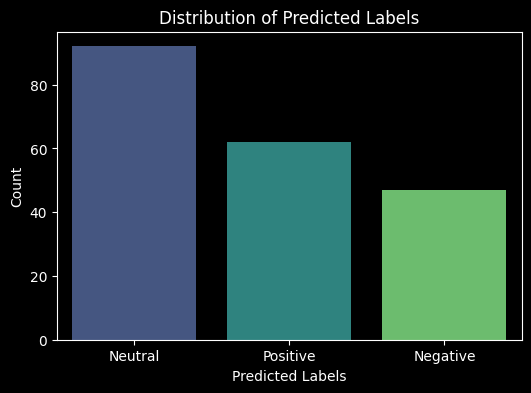

In [25]:
pred_label_counts = pd.Series(predicted_labels).value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.show()

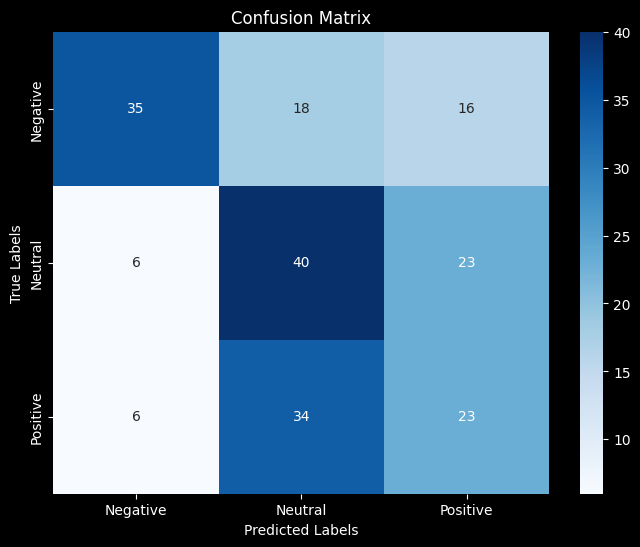

In [26]:

cm = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

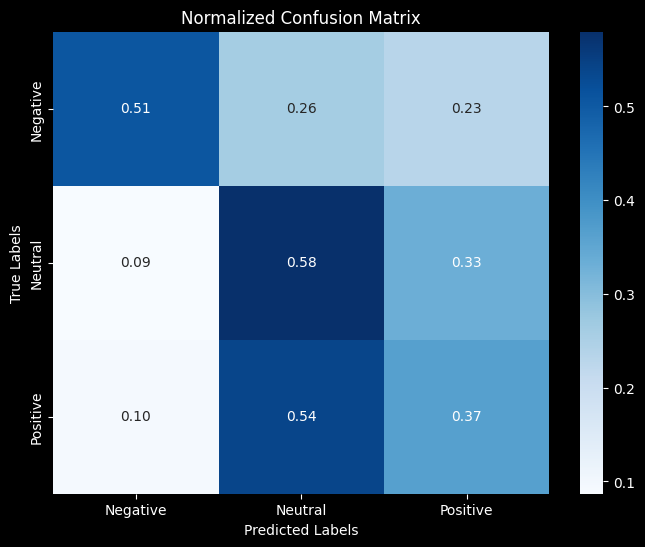

In [27]:
cm_normalized = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [28]:
report = classification_report(true_labels, predicted_labels, target_names=sorted_labels)
print(report)

              precision    recall  f1-score   support

    Negative       0.74      0.51      0.60        69
     Neutral       0.43      0.58      0.50        69
    Positive       0.37      0.37      0.37        63

    accuracy                           0.49       201
   macro avg       0.52      0.48      0.49       201
weighted avg       0.52      0.49      0.49       201



In [29]:

def get_probabilities(logits):
    return F.softmax(torch.tensor(logits), dim=-1).numpy()

probabilities = get_probabilities(predictions_output.predictions)

for i in range(5):
    print(f"Example {i+1}:")
    print(f"Text: {test_df['text'].iloc[i]}")
    print(f"True Label: {true_labels[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Probabilities: {probabilities[i]}")
    print("-" * 50)

Example 1:
Text: Dr bardzo czylelnie sie jasno prowadzi wykład jak chodzisz w sumie nie wiele musisz i uczyc .
True Label: Positive
Predicted Label: Positive
Probabilities: [0.27461106 0.33056337 0.39482567]
--------------------------------------------------
Example 2:
Text: Informacja na podstawie obecności .
True Label: Neutral
Predicted Label: Neutral
Probabilities: [0.32561406 0.34980583 0.32458013]
--------------------------------------------------
Example 3:
Text: Jeśli masz więcej odróbek ( lub jest jakiś ważny powód ) można się było z prowadzącą zajęcia dogadać .
True Label: Positive
Predicted Label: Positive
Probabilities: [0.32641873 0.33551767 0.3380636 ]
--------------------------------------------------
Example 4:
Text: Ogólnie BwE to pikuś 8 )
True Label: Neutral
Predicted Label: Neutral
Probabilities: [0.32948947 0.33815876 0.33235177]
--------------------------------------------------
Example 5:
Text: Jest to human , jego do trzeba się odzywać i trzeba coś robić , więc 

In [30]:
def preprocess_function(examples):
    tokens = tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )
    tokens['labels'] = [label2id[l] for l in examples["label"]]
    return tokens

tokenized_ds = dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=dataset["train"].column_names
)

print(tokenized_ds)



Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 804
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 201
    })
})


In [31]:
def extract_embeddings(model, tokenizer, dataset, device, batch_size=16):
    model.eval()
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=DataCollatorWithPadding(tokenizer=tokenizer)
    )
    embeddings = []
    labels = []
    
    model_input_keys = tokenizer.model_input_names

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting embeddings"):
            # Przygotowanie wejść
            inputs = {k: v.to(device) for k, v in batch.items() if k in model_input_keys}
            # Wywołanie modelu z output_hidden_states=True
            outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            # Ukryte stany to krotka wszystkich warstw
            hidden_states = outputs.hidden_states
            # Pobranie ostatniego ukrytego stanu
            last_hidden_state = hidden_states[-1]  # Kształt: [batch_size, seq_length, hidden_size]
            # Wyodrębnienie reprezentacji [CLS]
            cls_embeddings = last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
            labels.extend(batch['labels'].cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    return embeddings, labels

test_embeddings, test_labels_ids = extract_embeddings(
    model, 
    tokenizer, 
    tokenized_ds["test"], 
    device=device, 
    batch_size=16
)

test_labels = [id2label[label_id] for label_id in test_labels_ids]

test_predicted_labels = [id2label[pred] for pred in preds]

Extracting embeddings: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


In [32]:

pca = PCA(n_components=40, random_state=42)
embeddings_pca = pca.fit_transform(test_embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

df_visualization = pd.DataFrame({
    'TSNE-1': embeddings_tsne[:,0],
    'TSNE-2': embeddings_tsne[:,1],
    'True Label': test_labels,
    'Predicted Label': test_predicted_labels,
    'Text': test_df['text']
})

fig_true = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='True Label',
    hover_data=['True Label', 'Predicted Label', 'Text'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Kolor: Prawdziwe Etykiety)',
    width=1200,
    height=600
)

fig_true.show()

fig_pred = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='Predicted Label',
    hover_data=['True Label', 'Predicted Label', 'Text'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Kolor: Przewidywane Etykiety)',
    width=1200,
    height=600
)

fig_pred.show()

df_visualization['Correct'] = df_visualization['True Label'] == df_visualization['Predicted Label']

fig_correct = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='Correct',
    symbol='Correct',
    hover_data=['True Label', 'Predicted Label', 'Text'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Zaznaczenie Poprawnych/Niepoprawnych)',
    width=1200,
    height=600
)

fig_correct.show()

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
